# Notebook for Training ResNet on The TinyImageNet dataset. Notebook (2/4) in the End-to-End Scalable Deep Learning Pipeline on Hops.

ResNet is one of the state-of-the-art deep networks for computer vision. ResNet is based on the idea of residual learning. A residual network has so called "shortcut connections" parallel to the normal convolutional layers. Those shortcuts act like highways for gradients which allows to train extremely deep networks without suffering from vanishing or exploding gradients. Intuitively, by having the short-cut connections available during training, the network can learn which layers it doesn't need, since it can always fall-back on the shortcut (identity) connection.
![resnet1.png](./../images/resnet_1.png)

Despite the huge increase in the overall depth, a ResNet with 50 layers has roughly half the parameters in AlexNet, this is because ResNet relies only on small filters in the network. E.g a stack of several 3x3 filters uses the same number of parameters as a single 7x7 filter. 

ResNet come in different depths: Resnet18, Resnet34, Resnet50,Resnet101, Resnet152

For the deeper variants, ResNet uses "bottleneck building blocks" to lower the training time for the deepest networks. 

![bottlenneck.png](./../images/bottleneck.png)

ResNet uses batch notmalization right after each convolution and before the activation function. Typically ReLU is used as the activation function.


This notebook will read the TFRecords that were written by notebook number 1 ([Notebook number one](./Step1_Save_to_Featurestore.ipynb)) and feed them into ResNet for single-GPU training and distributed hyperparameter search using several GPUs. 

Specifically, this notebook reads TFRecords dataset called 'train_dataset_tinyimagenet' from the featurestore.

![step2.png](./../images/step2.png)

## Package Imports


In [129]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from hops import experiment, tensorboard, featurestore, hdfs
from tensorflow import keras
from tensorflow.python.keras.callbacks import TensorBoard
import numpy as np
import math
import json
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model

## Constants

In [71]:
HEIGHT = 64
WIDTH = 64
CHANNELS = 3
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 1000
INPUT_SHAPE = 12288
NUM_CLASSES = 200
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
TRAIN_DATASET = "train_dataset_tinyimagenet"
TEST_DATASET = "test_dataset_tinyimagenet"
VAL_DATASET = "val_dataset_tinyimagenet"
MODEL_NAME = "tinyimagenet_resnet50.h5"
HYPERPARAMS_FILE = "tinyimagenet_best_hyperparams.json"

In [72]:
TRAIN_DATASET_SIZE = featurestore.get_training_dataset(TRAIN_DATASET).count()
STEPS_PER_EPOCH = int(math.floor(float(TRAIN_DATASET_SIZE)/float(BATCH_SIZE)))

In [73]:
%%local
HYPERPARAMS_FILE = "tinyimagenet_best_hyperparams.json"

## Define Model

In [74]:
def define_model():
    """
    Defines the model to use for image classification. 
    
    Uses a pre-defined ResNet50 implementation provided by Keras, but uses randomly initialized weights,
    i.e pre-defined but not pre-TRAINED.
    
    Returns:
           ResNet50 model
    """
    model = ResNet50(weights=None, input_shape=(HEIGHT, WIDTH, CHANNELS), classes=NUM_CLASSES)
    return model

## Define Model Input

In [115]:
def create_tf_dataset(dataset_name, shuffle_buffer_size, batch_size, num_epochs):
    """
    Creates a Tensorflow Dataset from TFRecords on HopsFS stored in the feature store.
    
    Args:
        :dataset_name: name of the training dataset in the featurestore (TFRecords format)
        :shuffle_buffer_size: size of the shuffle buffer in memory for shuffling the dataset
        :batch_size: the size of the batch
        :num_epochs: number of epochs to repeat the dataset
    
    Returns:
           Tensorflow dataset
    """
    
    # Get Path and Schema from feature store metadata
    tf_record_schema = featurestore.get_training_dataset_tf_record_schema(dataset_name)
    dataset_dir = featurestore.get_training_dataset_path(dataset_name)
    
    input_files = tf.gfile.Glob(dataset_dir + "/part-r-*")
    dataset = tf.data.TFRecordDataset(input_files)

    def decode(example_proto):
        example = tf.parse_single_example(example_proto, tf_record_schema)
        label_int = example["label"]
        image_flat = example["image"]
        image = tf.reshape(image_flat, (HEIGHT,WIDTH,CHANNELS))
        label = tf.one_hot(label_int, NUM_CLASSES)
        return image, label

    dataset = dataset.map(decode).batch(batch_size).shuffle(shuffle_buffer_size)
    dataset = dataset.repeat(num_epochs)
    # prefetch 1 batch to make bottleneck on GPU bandwidth less likely
    dataset = dataset.prefetch(1)
    return dataset

In [116]:
def test_read_dataset():
    """
    Utility function for confirming that parsing the tfrecord files is working correctly
    """
    with tf.Session() as sess:
        dataset = create_tf_dataset(TRAIN_DATASET, SHUFFLE_BUFFER_SIZE, BATCH_SIZE, NUM_EPOCHS)
        dataset_iter = dataset.make_one_shot_iterator()
        for i in range(5):
            x,y = sess.run(dataset_iter.get_next())
            print("feature batch shape: {}, label batch shape: {}".format(x.shape, y.shape))

In [77]:
test_read_dataset()

feature batch shape: (100, 64, 64, 3), label batch shape: (100, 200)
feature batch shape: (100, 64, 64, 3), label batch shape: (100, 200)
feature batch shape: (100, 64, 64, 3), label batch shape: (100, 200)
feature batch shape: (100, 64, 64, 3), label batch shape: (100, 200)
feature batch shape: (100, 64, 64, 3), label batch shape: (100, 200)

## Define Train Loop

In [117]:
def train_fn(learning_rate, save_model):
    """
    Defines the training loop:
    
    1. Get Model
    2. Get Dataset
    3. Define custom metrics
    4. Compile Model
    5. Setup Tensorboard
    6. Fit model on train dataset
    7. Save Training history to HopsFS (Resources folder)
    8. Save Trained model to HopsFS (Resources Folder)
    9. Get the Validation Dataset
    10. Evaluate Model on Validation Dataset
    11. Save results on the validation set to HopsFS
    12. Return Validation Accuracy
    """
    # Tell Keras we are traning (in case it does different functionality between train/test time)
    tf.keras.backend.set_learning_phase(True)

    # 1. Get model
    print("Defning the model")
    model = define_model()
    print("Defining the model complete")
    
    # 2. Get the train dataset
    print("Getting the train dataset")
    train_dataset = create_tf_dataset(TRAIN_DATASET, SHUFFLE_BUFFER_SIZE, BATCH_SIZE, NUM_EPOCHS)
    print("Getting the train dataset complete")
    # 3. Define custom metrics
    def top3_acc(x, y):
        return metrics.top_k_categorical_accuracy(x, y, k=3)
    
    def top5_acc(x, y):
        return metrics.top_k_categorical_accuracy(x, y, k=5)
    
    # 4. Compile the model
    print("Compiling the model")
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate), loss='categorical_crossentropy',  
                  metrics=['accuracy', metrics.mae,top3_acc,top5_acc])
    print("Compiling the model complete")
    # 5. Setup Tensorboard
    print("Setting up tensorboard")
    tb_callback = TensorBoard(log_dir=tensorboard.logdir(), histogram_freq=0,
                             write_graph=True, write_images=True)
    callbacks = [tb_callback]
    callbacks.append(keras.callbacks.ModelCheckpoint(tensorboard.logdir() + '/checkpoint-{epoch}.h5',
                    monitor='acc', verbose=0, save_best_only=True))
    print("Setting up tensorboard complete")
    # 6. Fit model on training dataset
    print("Starting training...")
    history = model.fit(train_dataset, epochs=NUM_EPOCHS, steps_per_epoch = STEPS_PER_EPOCH, callbacks=callbacks)
    print("Training complete")
    
    # 7. Save training history to HopsFS
    print("Saving training history log...")
    results_path = hdfs.project_path() + "Resources/tinyimagenet_train_results_" + "lr=" + str(learning_rate) + ".json" 
    hdfs.dump(json.dumps(history.history), results_path)
    print("Training history saved, final train top1 accuracy: {}".format(history.history["acc"][-1]))
    
    # 8. Save trained model to HopsFS 
    if(save_model):
        try:
            print("Saving trained model..")
            # Keras can't save to HDFS in the current version so save to local fs first
            model.save(MODEL_NAME) #Keras can't save to HDFS in the current version so save to local fs first
            # copy from local fs to hdfs
            hdfs.copy_to_hdfs(MODEL_NAME, hdfs.project_path() + "Resources/", overwrite=True)
            print("Trained model saved")
        except:
            print("Exception while trying to save model to HDFS")
        
    # 9. Get the validation dataset
    print("Getting the validation dataset...")
    val_dataset = create_tf_dataset(VAL_DATASET, SHUFFLE_BUFFER_SIZE, BATCH_SIZE, 1)
    print("Got validation dataset complete.")
    
    # 10. Evaluate trained model on the validation dataset
    print("Evaluating trained model on validation dataset...")
    score = model.evaluate(val_dataset, verbose=1, steps=1)
    print("Evaluation on validation dataset complete.")
    
    # 11. Save validation results to HopsFS
    print("Saving validation results to HopsFS..")
    val_loss = score[0]
    val_top1_acc = score[1]
    val_mae = score[2]
    val_top3_acc = score[3]
    val_top5_acc = score[4]
    validation_results = {
        "loss": val_loss,
        "top1_acc": val_top1_acc,
        "mae": val_mae,
        "val_top3_acc": val_top3_acc,
        "val_top5_acc": val_top5_acc
    }
    val_results_path = hdfs.project_path() + "Resources/tinyimagenet_val_results_" + "lr=" + str(learning_rate) + ".json" 
    hdfs.dump(json.dumps(validation_results), val_results_path)
    print("Saved validation results: {}".format(validation_results))
    
    # 12. Return validation accuracy
    #return history.history["acc"][-1]
    return val_top1_acc

## HyperParameter Search Experiments

To run the differential evolution you should have started the jupyter notebook from the "Parallel Experiments" option, ideally using GPUs since we are training using a very compute-intensive network: ResNet50. If you use 5 parallel executors, then setting `population=5` is a good choice, and the number of generations will control for how many rounds the search will go on before returning. 

In [118]:
BATCH_SIZE = 100
NUM_EPOCHS = 20

In [ ]:
search_dict = {"learning_rate": [0.001, 0.01], "save_model" : [False, False]} # don't need to save model during hyperparam search
log_dir, best_params = experiment.differential_evolution(
    train_fn,
    search_dict,
    name='tiny_imagenet_hyperparam_search',
    description='Evolutionary search through the search space of hyperparameters with parallel executors to find the best parameters for the tinyimagenet dataset',
    local_logdir=True,
    population=4,
    generations = 6
    )

## Save the Best HyperParameters to HopsFS
The next notebook will read the best parameters and use those for training on a larger amount of epochs using a larger amount of GPUs

In [120]:
best_params

{'learning_rate': '0.004086662546226794', 'save_model': '0'}

In [121]:
hdfs.dump(json.dumps(best_params), "Resources/" + HYPERPARAMS_FILE)

## Plot Results of Best HyperParameter Combination

### Load Training Results from HopsFS

In [122]:
%%local
import json
from hops import hdfs
import matplotlib.pyplot as plt
from pylab import rcParams
# Read the best hyperparameters
best_hyperparams_path = "Resources/" + HYPERPARAMS_FILE
best_hyperparams = json.loads(hdfs.load(best_hyperparams_path))
best_learning_rate = best_hyperparams["learning_rate"]
# Read the training history for the training run with the best hyperparameters
results_path = hdfs.project_path() + "Resources/tinyimagenet_train_results_" + "lr=" + str(best_learning_rate) + ".json" 
results = json.loads(hdfs.load(results_path))

In [123]:
%%local
results

{'loss': [5.411390064445596,
  5.222174410669325,
  5.116018927668456,
  4.780339137980454,
  4.4961224836919165,
  4.197769415366419,
  3.8981625394597574,
  3.6129509233674995,
  3.3779140673160066,
  3.1467709290993446,
  2.8962555218423423,
  2.6263754996077124,
  2.284546881883759,
  1.9326494781492196,
  1.5513498628175952,
  1.0851616384603926,
  0.6480491159371766,
  0.40564116015726515,
  0.3199676515479457,
  0.2681495739255294],
 'acc': [0.009054697310470356,
  0.01697247675131099,
  0.027627581932698732,
  0.04670266684421948,
  0.07914502121637235,
  0.11595233486135557,
  0.1565292457367363,
  0.1990851497811158,
  0.2382390739644947,
  0.27630292084238944,
  0.32105782131354016,
  0.36813016951266414,
  0.43375565930365545,
  0.5073967380990311,
  0.5909156239725398,
  0.7019287993662462,
  0.81601568986638,
  0.8805464588781623,
  0.9041652169067196,
  0.9181189449555284],
 'mean_absolute_error': [0.009941208226630933,
  0.009922017659479325,
  0.009901096389290025,
  0

### Plot Loss/Epoch During Training

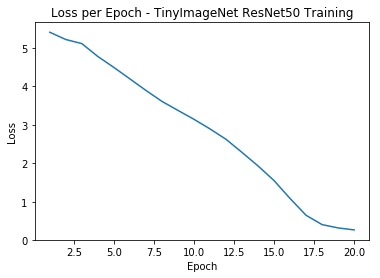

In [124]:
%%local
%matplotlib inline
y = results["loss"] #loss
x = list(range(1, len(y)+1))#epoch
plt.title("Loss per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)

### Plot Accuracy/Epoch During Training

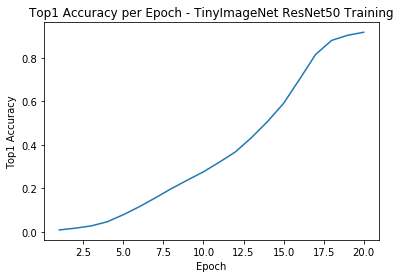

In [125]:
%%local
%matplotlib inline
y = results["acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Top1 Accuracy per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Top1 Accuracy")
plt.plot(x,y)

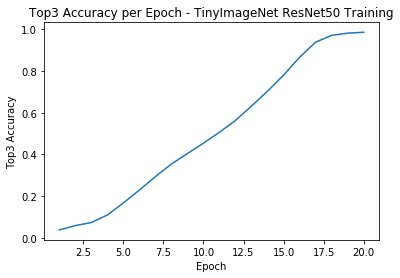

In [126]:
%%local
%matplotlib inline
y = results["top3_acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Top3 Accuracy per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Top3 Accuracy")
plt.plot(x,y)

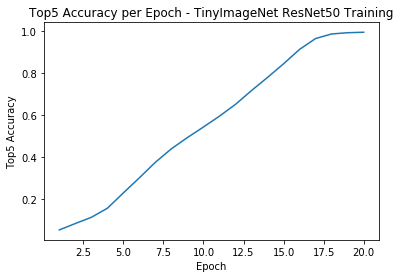

In [127]:
%%local
%matplotlib inline
y = results["top5_acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Top5 Accuracy per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Top5 Accuracy")
plt.plot(x,y)

## Run single training experiment with a set of hyperparameters using a single GPU

Running 30 epochs (1.5hours on single GPU) with the following learning rate yields Top1Acc: 0.73 | Top3Acc: 0.90 | Top5Acc: 0.94 on the training set:

- lr: 0.01
- batch_size: 100

The accuracy can be further improved by training more epochs, and to improve the accuracy on the validation set more regularization should be added to the model.

In [98]:
BATCH_SIZE = 100
NUM_EPOCHS = 30
LEARNING_RATE = 0.01
args_d = {}
args_d["learning_rate"] = [LEARNING_RATE]
args_d["save_model"] = [True]

In [96]:
experiment_result_path = experiment.launch(
    train_fn, 
    args_dict = args_d,
    name='tinyimagenet_resnet_150_epochs',
    description="Training TinyImageNet 150 epochs using hyperparameters found with differential evolution",
    local_logdir=True
)

Finished Experiment

In [114]:
learning_rate = LEARNING_RATE
train_results_path = hdfs.project_path() + "Resources/tinyimagenet_train_results_" + "lr=" + str(learning_rate) + ".json"
train_results = json.loads(hdfs.load(train_results_path))
train_results.keys()
print("train_acc1: {}, train_acc3: {}, train_acc5: {}, loss: {}".format(train_results["acc"][-1], train_results["top3_acc"][-1], train_results["top5_acc"][-1], train_results["loss"][-1]))

train_acc1: 0.7361346604141135, train_acc3: 0.9071022858434983, train_acc5: 0.9488583110523515, loss: 0.8728083318951905

In [110]:
learning_rate = LEARNING_RATE
val_results_path = hdfs.project_path() + "Resources/tinyimagenet_val_results_" + "lr=" + str(learning_rate) + ".json"
val_results = json.loads(hdfs.load(val_results_path))
print("val_acc1: {}, val_acc3: {}, val_acc5: {}, loss: {}".format(val_results["top1_acc"], val_results["val_top3_acc"], val_results["val_top5_acc"], val_results["loss"]))

val_acc1: 0.09000000357627869, val_acc3: 0.2199999988079071, val_acc5: 0.28999999165534973, loss: 8.212908744812012

## Plot Results

In [100]:
%%local
import json
from hops import hdfs
import matplotlib.pyplot as plt
from pylab import rcParams
LEARNING_RATE = 0.01
best_learning_rate = LEARNING_RATE
# Read the training history for the training run with the best hyperparameters
results_path = hdfs.project_path() + "Resources/tinyimagenet_train_results_" + "lr=" + str(best_learning_rate) + ".json" 
results = json.loads(hdfs.load(results_path))

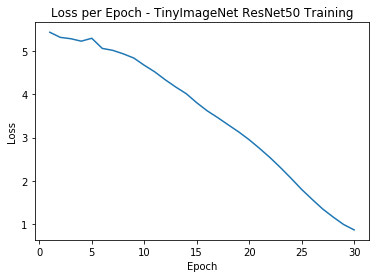

In [101]:
%%local
%matplotlib inline
y = results["loss"] #loss
x = list(range(1, len(y)+1))#epoch
plt.title("Loss per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)

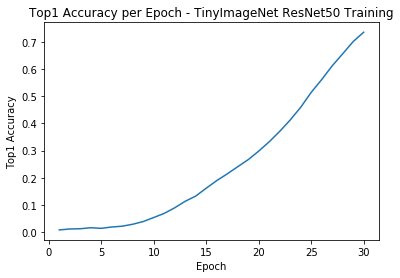

In [102]:
%%local
%matplotlib inline
y = results["acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Top1 Accuracy per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Top1 Accuracy")
plt.plot(x,y)

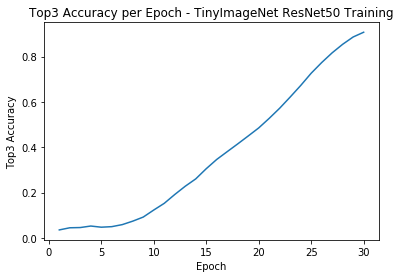

In [103]:
%%local
%matplotlib inline
y = results["top3_acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Top3 Accuracy per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Top3 Accuracy")
plt.plot(x,y)

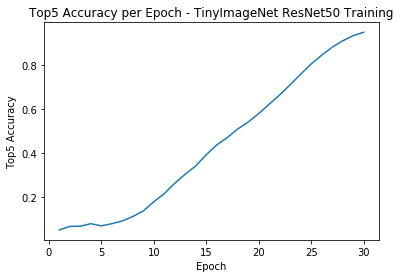

In [104]:
%%local
%matplotlib inline
y = results["top5_acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Top5 Accuracy per Epoch - TinyImageNet ResNet50 Training")
plt.xlabel("Epoch")
plt.ylabel("Top5 Accuracy")
plt.plot(x,y)

## Load Model and Evaluate on Validation Dataset

In [128]:
model_path_hdfs = hdfs.project_path() + "Resources/" + MODEL_NAME

In future releases of Tensorflow, Keras will be able to read directly from HDFS, but currently it is not supported. To get around this we can download the hdf5 model in the local file system and load it from there using keras function load_model()

In [131]:
local_path = hdfs.copy_to_local(model_path_hdfs, "")

In [139]:
def top3_acc(x, y):
    return metrics.top_k_categorical_accuracy(x, y, k=3)
    
def top5_acc(x, y):
    return metrics.top_k_categorical_accuracy(x, y, k=5)

In [140]:
model = load_model(MODEL_NAME)
model.compile(optimizer=tf.train.AdamOptimizer(LEARNING_RATE), loss='categorical_crossentropy',  
                  metrics=['accuracy', metrics.mae,top3_acc,top5_acc])

#### Evaluate on Validation Dataset

In [141]:
# We have 10 000 Test examples, we can evaluate in batches of 100 to speed up the process
BATCH_SIZE = 100
NUM_EPOCHS = 1
# get dataset path from the featurestore
val_dataset_path = featurestore.get_training_dataset_path(VAL_DATASET)
val_dataset = create_tf_dataset(VAL_DATASET, SHUFFLE_BUFFER_SIZE, BATCH_SIZE, 1)

In [142]:
score = model.evaluate(val_dataset, verbose=1, steps=1)
val_loss = score[0]
val_top1_acc = score[1]
val_mae = score[2]
val_top3_acc = score[3]
val_top5_acc = score[4]
validation_results = {
    "loss": val_loss,
    "top1_acc": val_top1_acc,
    "mae": val_mae,
    "val_top3_acc": val_top3_acc,
    "val_top5_acc": val_top5_acc
}

1/1 [==============================] - 26s 26s/step

In [143]:
validation_results

{'loss': 7.0366740226745605, 'top1_acc': 0.15000000596046448, 'mae': 0.00865943543612957, 'val_top3_acc': 0.3100000023841858, 'val_top5_acc': 0.36000001430511475}